# 1. Introduction



With these notebooks, we want to show how to use the scatseisnet package for exploring continuous seismograms for your task at hand. These tutorials allow to build a scattering network and calculate scattering coefficients from a small dataset. 

The scattering coefficients are well-adapted to data exploration methods such as dimensionality reduction and clustering methods, which we will also explore. We investigate different exploration methods which have been presented in Seydoux et al. ([2020](https://www.nature.com/articles/s41467-020-17841-x)), and Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455), [2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL098854), and [2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219)), and we hope that these notebooks will inspire your research.

## Contents of the tutorial

1. [Introduction](1_intro.ipynb) 
1. [Scattering network design](2_design.ipynb)
1. [Scattering transformation](3_transformation.ipynb)
1. [Independent component analysis](4_reduction.ipynb)
1. [Scattering coefficient reconstruction](5_reconstruction.ipynb)
1. [Clustering](6_clustering.ipynb)
1. [Seismogram atlas](7_atlas.ipynb)


## Installation requirements

This notebook requires the installation of the matplotlib and obspy libraries, which are not included in the default installation of the scatseisnet library. To install them, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html) and the [obspy wiki](https://github.com/obspy/obspy/wiki#installation).

> This tutorial was created by Léonard Seydoux and René Steinmann in 2023. Latest update in November 2025.

In [2]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

In [3]:
%config InlineBackend.figure_format = "svg"

## Load seismograms

The design of the scattering network and the data exploration method depend on the data and task at hand. Therefore, we will first define the data and task before diving into the details of scatseisnet.

We choose a one-day-long three-component seismogram from station SV13 from the temporary KISS network, which was installed in the Klyuchevskoy volcano group in 2015/2016. In our study Steinmann et al. ([2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219)), we analyze the whole recording period of SV13. However, for this tutorial it is more convenient to focus on a single day.

We select the 4th of December 2015, which marks the onset of tremor activity due to the reactivation of the Klyuchevskoy volcano. We download the data from the [GFZ data center](https://geofon.gfz-potsdam.de/) using ObsPy's FDSN client.

In [7]:
# Connect to the datacenter
client = Client("GFZ")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="X9",
    station="SV13",
    location="*",
    channel="*",
    starttime=UTCDateTime("2015-12-04T00:00"),
    endtime=UTCDateTime("2015-12-05T00:00"),
)

## Preprocess seismograms

Before exploring the data, it is helpful to clean and standardize the seismograms. In the next code cell, we apply a minimal yet practical pipeline:

- Merge: combine partially overlapping or gappy segments into continuous traces per channel.
- Detrend (linear): remove linear trends to reduce DC bias and avoid filter edge effects.
- High-pass filter at 1 Hz: suppress long-period drift and microseisms while emphasizing tremor and transient events.

After processing, we quickly inspect the result with a plot and save the stream to MiniSEED for reuse in later notebooks.

Tips for adaptation:
- Tune the corner frequency and filter type to your task and the station’s noise characteristics.
- Consider adding a taper, resampling, or instrument response removal if needed.
- Always visualize after each major step to verify that processing behaves as expected.
- For more options, see ObsPy’s signal processing routines: https://docs.obspy.org/packages/obspy.signal.html

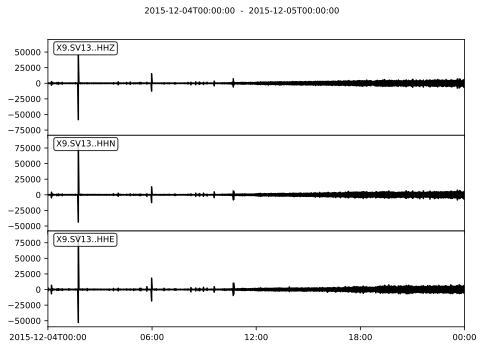

In [ ]:
# Preprocess the data: merge, detrend, filter
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)

# Plot the seismograms
stream.plot(linewidth=0.2, rasterized=True, size=(700, 500))

# Save the seismograms to a MiniSEED file
stream.write("../example/stream.mseed", format="MSEED", encoding="FLOAT64")

## Define task

We observe in these seismograms that there is an increase in volcanic tremor activity throughout the day, starting from low levels in the morning and intensifying towards the evening. Additionally, there are several transient seismic events scattered throughout the day.

With scatseisnet we want to **explore this one-day long three-component seismogram and identify clusters related to the tremor and non-tremor activity**. Note that this is only a toy example. The power of scatseisnet and data exploration lies in exploring large continuous time series when manual investigation is not feasible.